<img src = "https://raw.githubusercontent.com/barcelonagse-datascience/academic_files/master/images/BSE_DSC_HEADER.jpg">

# Project: Decision trees and Ensembles

## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree and ensemble models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 10%
+ Data preparation - 15%
+ DT method(s) have been used - 20%
+ Length of stay for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Ensemble models have been used - 10%
+ Complexity of the ensemble - 5% (random forests/boosting are simple ensembles using only trees, stacking is a more complex ensemble model)
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


In [344]:
# imports

%matplotlib inline
import matplotlib.pylab as plt 

#from utils.helper_functions import *

from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn import preprocessing
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
import sklearn
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap

In [345]:
# Training dataset
train=pd.read_csv('mimic_train.csv')
primary_diagnosis = pd.read_csv('MIMIC_metadata_diagnose.csv')
secondary_diagnosis = pd.read_csv('MIMIC_diagnoses.csv')
train.head()
SEED = 42

In [346]:
# Test dataset (to produce predictions)
test=pd.read_csv('mimic_test_los.csv')
test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [347]:
test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [348]:
pred_sample=pd.read_csv('mimic_kaggle_los_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,LOS
663,200011,3.701046
4608,200044,3.701046
1186,200049,3.701046
1245,200063,3.701046
606,200081,3.701046


Rename secondary_diagnosis columns to merge with train dataset and get SEQ_NUM

In [349]:
secondary_diagnosis.columns = ['subject_id', 'hadm_id','SEQ_NUM','ICD9_diagnosis']
train = train.merge(secondary_diagnosis, how='inner', left_on=['subject_id', 'hadm_id', 'ICD9_diagnosis'], right_on=['subject_id', 'hadm_id', 'ICD9_diagnosis'])

In [350]:
y_var  = 'LOS'
# rem_vars = ['HOSPITAL_EXPIRE_FLAG'] 
# train.drop(columns=rem_vars, inplace=True)
#test.drop(columns=rem_vars[0], inplace=True)

In [351]:
train.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
DiasBP_Max              2209
DiasBP_Mean             2209
MeanBP_Min              2186
MeanBP_Max              2186
MeanBP_Mean             2186
RespRate_Min            2189
RespRate_Max            2189
RespRate_Mean           2189
TempC_Min               2497
TempC_Max               2497
TempC_Mean              2497
SpO2_Min                2203
SpO2_Max                2203
SpO2_Mean               2203
Glucose_Min              253
Glucose_Max              253
Glucose_Mean             253
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION      

In [352]:
train.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS,SEQ_NUM
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761,1.0
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582,1.0
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626,1.0
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734,1.0
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654,1.0


Drop columns that contain 90% or more of nulls.

In [353]:
#limitPer = len(train) * .70
limitPer = len(train) * .90
train.dropna(thresh=limitPer, axis=1, inplace=True)

Checking dataset after removing columns with majority of NANs

In [354]:
train.isnull().sum()

HOSPITAL_EXPIRE_FLAG      0
subject_id                0
hadm_id                   0
icustay_id                0
Glucose_Min             253
Glucose_Max             253
Glucose_Mean            253
GENDER                    0
DOB                       0
ADMITTIME                 0
Diff                      0
ADMISSION_TYPE            0
INSURANCE                 0
RELIGION                  0
MARITAL_STATUS          722
ETHNICITY                 0
DIAGNOSIS                 0
ICD9_diagnosis            0
FIRST_CAREUNIT            0
LOS                       0
SEQ_NUM                   0
dtype: int64

DIAGNOSIS: Extract mean lenght of stay by Diagnosis.

In [355]:
# # group the DataFrame by diagnosis and calculate the mean length of stay
# meanLOS_by_diag = train.groupby('DIAGNOSIS')['LOS'].mean()

# # convert the resulting Pandas Series to a DataFrame
# df_meanLOS_by_diag = meanLOS_by_diag.to_frame()

# # reset the index to include the diagnosis column as a regular column
# df_meanLOS_by_diag = df_meanLOS_by_diag.reset_index()

# # rename the columns to indicate they contain the diagnosis and mean length of stay
# df_meanLOS_by_diag = df_meanLOS_by_diag.rename(columns={'DIAGNOSIS': 'DIAGNOSIS', 'LOS': 'Mean_LOS_Diagnosis'})

# # merge the mean length of stay with the original DataFrame
# train = pd.merge(train, df_meanLOS_by_diag, on='DIAGNOSIS', how='left')
# test = pd.merge(test, df_meanLOS_by_diag, on='DIAGNOSIS', how='left')

DIAGNOSIS: Extract how many patients die and how many live for each diagnosis to calculate probability of death.

In [356]:
dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 1]
not_dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 0]
dead_df = pd.DataFrame(dead['DIAGNOSIS'].value_counts())
not_dead_df = pd.DataFrame(not_dead['DIAGNOSIS'].value_counts())
dead_df.rename(columns={'DIAGNOSIS': 'Diagnosis Count Dead'}, inplace=True)
not_dead_df.rename(columns={'DIAGNOSIS': 'Diagnosis Count Live'}, inplace=True)
dead_df['DIAGNOSIS'] = dead_df.index
not_dead_df['DIAGNOSIS'] = not_dead_df.index

train = pd.merge(train, dead_df, on='DIAGNOSIS', how='left')
train = pd.merge(train, not_dead_df, on='DIAGNOSIS', how='left')
test = pd.merge(test, dead_df, on='DIAGNOSIS', how='left')
test = pd.merge(test, not_dead_df, on='DIAGNOSIS', how='left')
train['Diagnosis Count Dead'] = train['Diagnosis Count Dead'].fillna(0)
train['Diagnosis Count Live'] = train['Diagnosis Count Live'].fillna(0)
test['Diagnosis Count Dead'] = test['Diagnosis Count Dead'].fillna(0)
test['Diagnosis Count Live'] = test['Diagnosis Count Live'].fillna(0)
train['Diagnosis Prob Death'] = train['Diagnosis Count Dead'] / (train['Diagnosis Count Dead']+train['Diagnosis Count Live']) 
test['Diagnosis Prob Death'] = test['Diagnosis Count Dead'] / (test['Diagnosis Count Dead']+test['Diagnosis Count Live'])
train.drop(columns=['Diagnosis Count Dead','Diagnosis Count Live'], axis=1, inplace=True)
test.drop(columns=['Diagnosis Count Dead','Diagnosis Count Live'], axis=1, inplace=True)

ICD9_diagnosis: same process as DIAGNOSIS

In [357]:
# # group the DataFrame by diagnosis and calculate the mean length of stay
# meanLOS_by_diag = train.groupby('ICD9_diagnosis')['LOS'].mean()

# # convert the resulting Pandas Series to a DataFrame
# df_meanLOS_by_diag = meanLOS_by_diag.to_frame()

# # reset the index to include the diagnosis column as a regular column
# df_meanLOS_by_diag = df_meanLOS_by_diag.reset_index()

# # rename the columns to indicate they contain the diagnosis and mean length of stay
# df_meanLOS_by_diag = df_meanLOS_by_diag.rename(columns={'ICD9_diagnosis': 'ICD9_diagnosis', 'LOS': 'Mean_LOS_ICD9_diagnosis'})

# # merge the mean length of stay with the original DataFrame
# train = pd.merge(train, df_meanLOS_by_diag, on='ICD9_diagnosis', how='left')
# test = pd.merge(test, df_meanLOS_by_diag, on='ICD9_diagnosis', how='left')

In [358]:
dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 1]
not_dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 0]
dead_df = pd.DataFrame(dead['ICD9_diagnosis'].value_counts())
not_dead_df = pd.DataFrame(not_dead['ICD9_diagnosis'].value_counts())
dead_df.rename(columns={'ICD9_diagnosis': 'ICD9_Diagnosis Count Dead'}, inplace=True)
not_dead_df.rename(columns={'ICD9_diagnosis': 'ICD9_Diagnosis Count Live'}, inplace=True)
dead_df['ICD9_diagnosis'] = dead_df.index
not_dead_df['ICD9_diagnosis'] = not_dead_df.index

train = pd.merge(train, dead_df, on='ICD9_diagnosis', how='left')
train = pd.merge(train, not_dead_df, on='ICD9_diagnosis', how='left')
test = pd.merge(test, dead_df, on='ICD9_diagnosis', how='left')
test = pd.merge(test, not_dead_df, on='ICD9_diagnosis', how='left')
train['ICD9_Diagnosis Count Dead'] = train['ICD9_Diagnosis Count Dead'].fillna(0)
train['ICD9_Diagnosis Count Live'] = train['ICD9_Diagnosis Count Live'].fillna(0)
test['ICD9_Diagnosis Count Dead'] = test['ICD9_Diagnosis Count Dead'].fillna(0)
test['ICD9_Diagnosis Count Live'] = test['ICD9_Diagnosis Count Live'].fillna(0)
train['ICD9_Diagnosis Prob Death'] = train['ICD9_Diagnosis Count Dead'] / (train['ICD9_Diagnosis Count Dead']+train['ICD9_Diagnosis Count Live']) 
test['ICD9_Diagnosis Prob Death'] = test['ICD9_Diagnosis Count Dead'] / (test['ICD9_Diagnosis Count Dead']+test['ICD9_Diagnosis Count Live'])
train.drop(columns=['ICD9_Diagnosis Count Dead','ICD9_Diagnosis Count Live'], axis=1, inplace=True)
test.drop(columns=['ICD9_Diagnosis Count Dead','ICD9_Diagnosis Count Live'], axis=1, inplace=True)

Converting admit time from string to datetime and extract if the patient was admit at night (urgency)

In [359]:
#Converting admit time from string to datetime and extract if the patient was admit at night (urgency)
train['ADMITTIME'] = pd.to_datetime(train['ADMITTIME'])
test['ADMITTIME'] = pd.to_datetime(test['ADMITTIME'])

Take day of the week the person was admit in the hospital

In [360]:
train['day_of_week'] = train['ADMITTIME'].dt.day_name()
test['day_of_week'] = test['ADMITTIME'].dt.day_name()

In [361]:
train['month'] = train['ADMITTIME'].apply(lambda x: x.month)
train['year'] = train['ADMITTIME'].apply(lambda x: x.year)
train['hour'] = train['ADMITTIME'].apply(lambda x: x.hour)
test['month'] = test['ADMITTIME'].apply(lambda x: x.month)
test['year'] = test['ADMITTIME'].apply(lambda x: x.year)
test['hour'] = test['ADMITTIME'].apply(lambda x: x.hour)
train['night_entrance']=np.where((train['hour'] > 22) | (train['hour'] < 6) , 1, 0)
test['night_entrance']=np.where((test['hour'] > 22) | (test['hour'] < 6) , 1, 0)

Getting Age

In [362]:
from datetime import timedelta
train['Diff'] = train['Diff'].astype(int)
train['Diff'] = train.apply(lambda x: timedelta(days=-x.Diff),axis=1)
train['DOB'] = pd.to_datetime(train['DOB'])
train['DOB'] = train.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
train['year_age']= train.apply(lambda x: (x.DOB.year),axis=1)

test['Diff'] = test['Diff'].astype(int)
test['Diff'] = test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
test['DOB'] = pd.to_datetime(test['DOB'])
test['DOB'] = test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
test['year_age']= test.apply(lambda x: (x.DOB.year),axis=1)

#drop_col = ['month', 'year', 'hour', 'ADMITTIME', 'Diff']
drop_col = ['month', 'year', 'Diff']
test.drop(columns=drop_col, inplace=True)
train.drop(columns=drop_col, inplace=True)

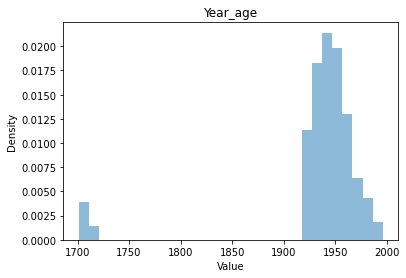

In [363]:
#cheking distribution
plt.hist(train['year_age'], bins=30, density=True, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Year_age')
plt.show()

Edit outliers from year_age to the IQ limits

In [364]:
print(X_train.shape)
def IQs_outliers (col):

    Q2 = col.quantile(q=0.5)
    Q1 = col.quantile(q=0.25)
    Q3 = col.quantile(q=0.75)
    IQR = Q3 - Q2
    IQ_menor = round(Q1 - 1.5*IQR)
    IQ_mayor = round(Q3 + 1.5*IQR) 

    return IQ_menor, IQ_mayor

m1, M1 = IQs_outliers(train['year_age'])
m2, M2 = IQs_outliers(test['year_age'])

train.loc[train['year_age'] < m1] = m1
train.loc[train['year_age'] > M1] = M1
test.loc[test['year_age'] < m2] = m2
test.loc[test['year_age'] > M2] = M2


(20885, 53)


After fitting my model, the following features I decided to drop as reduce the performance:
    
    - Mean_LOS_Diagnosis: Incorporate the target into the new features, even though the model does not have access to the test target, it will have indirect access to it through the features added. So it will overestimate the performance of my model. So,I decided not to add this feature as it decrease my performance.
    
    - Mean_LOS_ICD9_diagnosis: Incorporate the target into the new features, even though the model does not have access to the test target, it will have indirect access to it through the features added. So it will overestimate the performance of my model. So,I decided not to add this feature as it decrease my performance.

In [365]:
#Saving numerical columns in a list
#numeric = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
#        'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
#        'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
#        'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
#        'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
#        'Glucose_Mean','Diagnosis Prob Death', 'year_age']
numeric = ['Glucose_Min', 'Glucose_Max','Glucose_Mean']

In [366]:
# Drop Non-numeric
nonnumeric = ['subject_id', 'hadm_id', 'icustay_id', 'RELIGION','ICD9_diagnosis', 'DIAGNOSIS', 'ETHNICITY', 'DOB', 'ADMITTIME']

test.drop(columns=nonnumeric, inplace=True)
train.drop(columns=nonnumeric, inplace=True)
train.drop(columns='HOSPITAL_EXPIRE_FLAG', inplace=True)

In [367]:
#Grabbing categorical variables to convert to dummies
cat = ['GENDER','ADMISSION_TYPE','INSURANCE','FIRST_CAREUNIT', 'night_entrance', 'MARITAL_STATUS', 'day_of_week']
train = pd.get_dummies(train, columns=cat, drop_first=False)
test = pd.get_dummies(test, columns=cat, drop_first=False)

In [368]:
#In order to impute remaining NANs of numerical variables, need to set my training and test set in same format and order:
train_cols = set(train.columns)
test_cols = set(test.columns)

columns_not_in_test = train_cols - test_cols
for c in columns_not_in_test:
    test[c]=0
desired_order = list(train.columns)
test = test[desired_order]

In [369]:
print(test.shape)
print(train.shape)

(5221, 54)
(20885, 54)


In [370]:
test.drop(columns='LOS', inplace=True)

In [371]:
#Impute Values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

#imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
imp_mean = IterativeImputer(random_state=0)

X_train = train.loc[:,train.columns != y_var]
imp_mean.fit(X_train)
X_train = pd.DataFrame(imp_mean.transform(X_train),columns=X_train.columns)
#X_test = pd.DataFrame(imp_mean.transform(X_train),columns=test.columns)
X_test = pd.DataFrame(imp_mean.transform(X_test),columns=test.columns)

[IterativeImputer] Early stopping criterion not reached.


In [372]:
y_train = train[y_var]

In [373]:
#Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#y_train = train[y_var]
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train=pd.DataFrame(X_train, columns=test.columns)
X_test=pd.DataFrame(X_test, columns=test.columns)

Review distribution of numerical variables that feed model

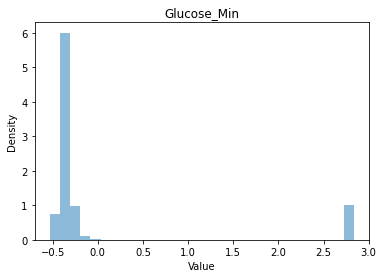

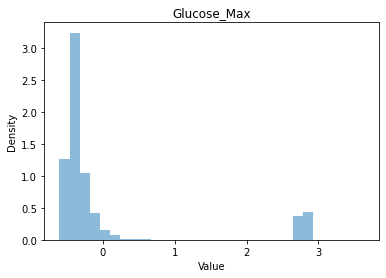

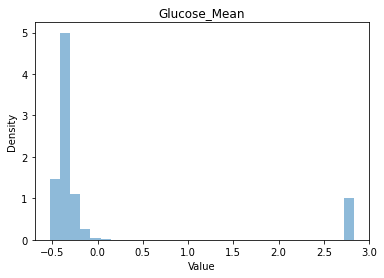

In [374]:
for col in numeric:
    # Create a histogram with a kernel density estimate
    plt.hist(X_train[col], bins=30, density=True, alpha=0.5)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(col)
    plt.show()

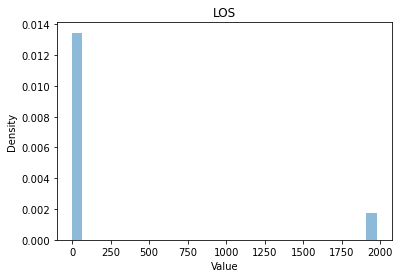

In [375]:
#cheking y_train distribution
plt.hist(y_train, bins=30, density=True, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('LOS')
plt.show()

It might help scaling into Log(LOS) if target values are very dispersed and when there are some observations with very high target values. This is not the case, so i will keep the y_train as it is

Try to improve performance by using other tree-type models and tuning hyperparameters

In [376]:
X_train

,Glucose_Min,Glucose_Max,Glucose_Mean,SEQ_NUM,Diagnosis Prob Death,ICD9_Diagnosis Prob Death,hour,year_age,GENDER_1912,GENDER_1976,...,MARITAL_STATUS_WIDOWED,day_of_week_1912,day_of_week_1976,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,-0.351201,-0.274349,-0.321669,-0.358063,-0.358131,-0.358089,-0.363903,-0.397502,-0.236583,-0.254133,...,-0.348429,-0.236583,-0.254133,2.505901,-0.413774,-0.317816,-0.315986,-0.392747,-0.407085,-0.410913
1,-0.364883,-0.498793,-0.422178,-0.358063,-0.358246,-0.358246,-0.344344,1.381030,-0.236583,-0.254133,...,-0.348429,-0.236583,-0.254133,-0.399058,-0.413774,3.146476,-0.315986,-0.392747,-0.407085,-0.410913
2,-0.315286,-0.069346,-0.222759,-0.358063,-0.358102,-0.357923,-0.342714,-0.160365,-0.236583,-0.254133,...,-0.348429,-0.236583,-0.254133,-0.399058,-0.413774,3.146476,-0.315986,-0.392747,-0.407085,-0.410913
3,-0.356332,-0.435171,-0.383907,-0.358063,-0.358246,-0.358246,-0.367162,-0.516071,-0.236583,-0.254133,...,2.870028,-0.236583,-0.254133,2.505901,-0.413774,-0.317816,-0.315986,-0.392747,-0.407085,-0.410913
4,-0.375144,-0.438705,-0.404782,-0.358063,-0.358010,-0.358213,-0.376942,-0.931062,-0.236583,-0.254133,...,2.870028,-0.236583,-0.254133,-0.399058,-0.413774,-0.317816,-0.315986,-0.392747,-0.407085,2.433606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,-0.366593,-0.500560,-0.423917,-0.358063,-0.357538,-0.358067,-0.342714,0.136058,-0.236583,-0.254133,...,-0.348429,-0.236583,-0.254133,2.505901,-0.413774,-0.317816,-0.315986,-0.392747,-0.407085,-0.410913
20881,-0.424741,-0.435171,-0.421184,-0.358063,-0.358046,-0.358246,-0.370422,-1.346053,-0.236583,-0.254133,...,-0.348429,-0.236583,-0.254133,-0.399058,2.416777,-0.317816,-0.315986,-0.392747,-0.407085,-0.410913
20882,-0.453815,0.132123,-0.270834,-0.358063,-0.358111,-0.358246,-0.352493,0.076773,-0.236583,-0.254133,...,-0.348429,-0.236583,-0.254133,-0.399058,-0.413774,-0.317816,-0.315986,-0.392747,2.456492,-0.410913
20883,2.728937,2.698201,2.724722,2.736642,2.736668,2.736668,2.736141,-1.938897,4.226855,-0.254133,...,-0.348429,4.226855,-0.254133,-0.399058,-0.413774,-0.317816,-0.315986,-0.392747,-0.407085,-0.410913


In [377]:
X_test

,Glucose_Min,Glucose_Max,Glucose_Mean,SEQ_NUM,Diagnosis Prob Death,ICD9_Diagnosis Prob Death,hour,year_age,GENDER_1912,GENDER_1976,...,MARITAL_STATUS_WIDOWED,day_of_week_1912,day_of_week_1976,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,-0.541638,-0.681306,-0.601914,-0.360262,-0.358826,-0.358826,-0.380795,-115.314249,-1.292554,-1.318716,...,-1.469831,-1.292554,-1.318716,6.880482,-1.584983,-1.418823,-1.415833,-1.546997,-1.572802,-1.579762
1,-0.541661,-0.681703,-0.602089,-0.360262,-0.358826,-0.358826,-0.380763,-115.208810,-1.292554,-1.318716,...,-1.469831,-1.292554,-1.318716,-1.558305,-1.584983,10.582497,-1.415833,-1.546997,-1.572802,-1.579762
2,-0.541576,-0.680944,-0.601742,-0.360262,-0.358826,-0.358826,-0.380760,-115.300191,-1.292554,-1.318716,...,-1.469831,-1.292554,-1.318716,-1.558305,-1.584983,10.582497,-1.415833,-1.546997,-1.572802,-1.579762
3,-0.541647,-0.681591,-0.602022,-0.360262,-0.358826,-0.358826,-0.380800,-115.321278,-1.292554,-1.318716,...,8.888635,-1.292554,-1.318716,6.880482,-1.584983,-1.418823,-1.415833,-1.546997,-1.572802,-1.579762
4,-0.541679,-0.681597,-0.602058,-0.360262,-0.358826,-0.358826,-0.380816,-115.345881,-1.292554,-1.318716,...,8.888635,-1.292554,-1.318716,-1.558305,-1.584983,-1.418823,-1.415833,-1.546997,-1.572802,6.511527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,-0.541664,-0.681706,-0.602092,-0.360262,-0.358825,-0.358826,-0.380760,-115.282617,-1.292554,-1.318716,...,-1.469831,-1.292554,-1.318716,6.880482,-1.584983,-1.418823,-1.415833,-1.546997,-1.572802,-1.579762
20881,-0.541764,-0.681591,-0.602087,-0.360262,-0.358826,-0.358826,-0.380805,-115.370483,-1.292554,-1.318716,...,-1.469831,-1.292554,-1.318716,-1.558305,6.427038,-1.418823,-1.415833,-1.546997,-1.572802,-1.579762
20882,-0.541813,-0.680588,-0.601825,-0.360262,-0.358826,-0.358826,-0.380776,-115.286132,-1.292554,-1.318716,...,-1.469831,-1.292554,-1.318716,-1.558305,-1.584983,-1.418823,-1.415833,-1.546997,6.627270,-1.579762
20883,-0.536370,-0.676053,-0.596614,-0.355251,-0.353817,-0.353817,-0.375742,-115.405630,18.629723,-1.318716,...,-1.469831,18.629723,-1.318716,-1.558305,-1.584983,-1.418823,-1.415833,-1.546997,-1.572802,-1.579762


In [378]:
%%time
# models
scores = {}
models = [XGBRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, 1],
              'max_depth': range(3, 10),
              'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [xgb_params, dectree_params ,randomforest_params, adab_params, gb_params]
names = ['XGB_Regressor', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

#gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = GridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
    y_pred = best_model.predict(X_train)
    
    mse = mean_squared_error(y_train, y_pred)
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    print(mse)

Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 9, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 42}
XGB_Regressor MSE score on train sample: 25.8164339498314
18.758986602489095
Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 5, 'random_state': 42}
DecisionTree_Regressor MSE score on train sample: 24.004335794984936
23.83722305166414
Grid-Searching for model RandomForest_Regressor...
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 50, 'random_state': 42}
RandomForest_Regressor MSE score on train sample: 23.914315764348526
23.628526517810975
Grid-Searching for model AdaBoost_Regressor...
Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learni

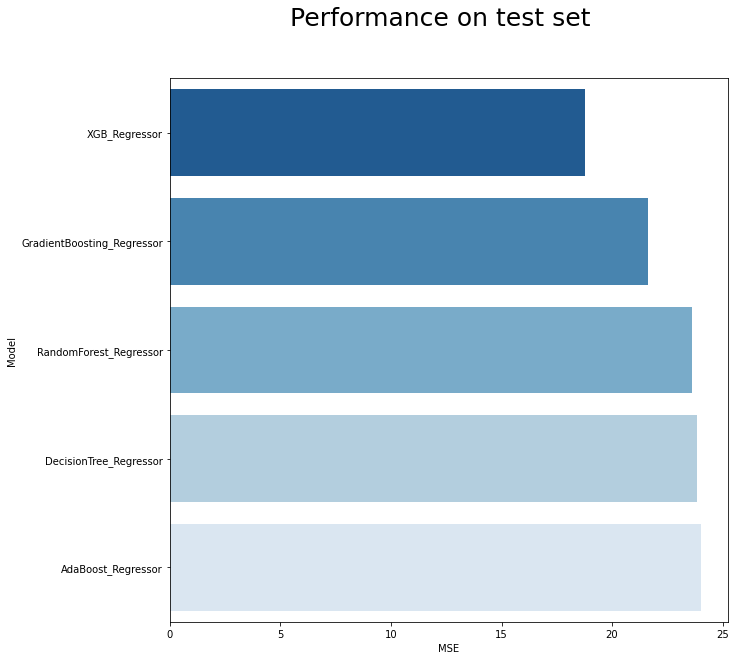

In [379]:
import seaborn as sns
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()

ranking.columns = ['Model', 'Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Performance on test set", fontsize=25)
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

 Ensembling techniques

In [380]:
from mlens.ensemble import SuperLearner
models = [DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor()]
meta_learners = [
    DecisionTreeRegressor(max_depth= 5, max_features= 9, min_samples_leaf= 6, random_state= SEED),
    RandomForestRegressor(max_depth= 5, max_features= 9, min_samples_leaf= 6, n_estimators= 100, random_state= SEED),
    GradientBoostingRegressor(learning_rate= 0.05, max_depth= 5, max_features= 8, n_estimators= 100, random_state= SEED)
]

meta_learners_ = ['DecisionTrees', 'RandomForest', 'GradientBoosting']

for i, meta_learner in enumerate(meta_learners):
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models, proba=False)
    super_learner.add_meta(meta_learner, proba=False)
    super_learner.fit(X_train, y_train)
    y_pred = super_learner.predict(X_train)
    
    mse = mean_squared_error(y_train, y_pred)
    scores[f'Stacking{meta_learners_[i]}'] = (super_learner, mse)
    print(f'Super Learner with {meta_learners_[i]} MSE: {mse}')

Super Learner with DecisionTrees MSE: 20.61063517131014
Super Learner with RandomForest MSE: 19.728153573970427
Super Learner with GradientBoosting MSE: 32.071374487177934


Stacked Generalization with Feature Propagation 

In [381]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [382]:
features_d = X_train.columns

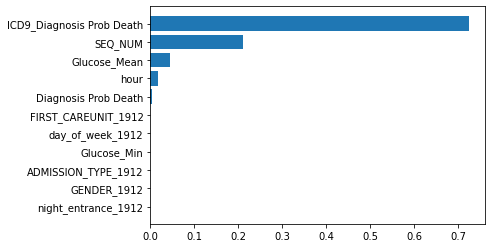

In [383]:
xgb_opt = models[-1].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), features_d)

In [384]:
feat_to_prop = [features_d[i] for i in feat_indexes_xgb][-5:]
pointer = [i for i, feat in enumerate(features_d) if feat in feat_to_prop]
X_train.columns[pointer]

Index(['Glucose_Mean', 'SEQ_NUM', 'Diagnosis Prob Death',
       'ICD9_Diagnosis Prob Death', 'hour'],
      dtype='object')

In [385]:
for i, meta_learner in enumerate(meta_learners):
    print(f'\nStackingPropagating {meta_learners_[i]}')
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models, propagate_features=pointer, proba=False)
    super_learner.add_meta(meta_learner, proba=False)
    super_learner.fit(X_train.values, y_train)
    
    y_pred = super_learner.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    
    print(f'Super Learner with {meta_learners_[i]} MSE: {mse}')


StackingPropagating DecisionTrees


X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but RandomForestRegressor was fitted without feature names


InvalidIndexError: (slice(0, None, None), [2, 3, 4, 5, 6])

 Fully connected feedforward Neural Network

In [410]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

input_shape = X_train.shape[1]
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Define the range of epochs to try
epochs_list = range(10, 91, 5)

# Create empty lists to store the MSE values and corresponding epoch values
mse_list = []
epoch_list = []

# Loop over the range of epochs and train the model for each epoch value
for i in epochs_list:
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    model.fit(X_train, y_train, epochs=i, batch_size=32, validation_split=0.2)
    
    # Make predictions using the trained model
    y_pred = model.predict(X_train)
    
    # Calculate the MSE and store it in the list
    mse = mean_squared_error(y_train, y_pred)
    mse_list.append(mse)
    epoch_list.append(i)

Epoch 1/10
523/523 [==============================] - 1s 2ms/step - loss: 132862.4688 - mean_squared_error: 132862.4688 - val_loss: 25.0480 - val_mean_squared_error: 25.0480
Epoch 2/10
523/523 [==============================] - 1s 2ms/step - loss: 25.2557 - mean_squared_error: 25.2557 - val_loss: 24.3961 - val_mean_squared_error: 24.3961
Epoch 3/10
523/523 [==============================] - 1s 1ms/step - loss: 24.8177 - mean_squared_error: 24.8177 - val_loss: 24.3094 - val_mean_squared_error: 24.3094
Epoch 4/10
523/523 [==============================] - 1s 1ms/step - loss: 24.6758 - mean_squared_error: 24.6758 - val_loss: 24.2332 - val_mean_squared_error: 24.2332
Epoch 5/10
523/523 [==============================] - 1s 1ms/step - loss: 24.5751 - mean_squared_error: 24.5751 - val_loss: 24.2292 - val_mean_squared_error: 24.2292
Epoch 6/10
523/523 [==============================] - 1s 1ms/step - loss: 24.5116 - mean_squared_error: 24.5116 - val_loss: 24.2120 - val_mean_squared_error: 24.2

523/523 [==============================] - 1s 2ms/step - loss: 22.9690 - mean_squared_error: 22.9690 - val_loss: 24.9675 - val_mean_squared_error: 24.9675
Epoch 5/25
523/523 [==============================] - 1s 2ms/step - loss: 24.7262 - mean_squared_error: 24.7262 - val_loss: 25.0488 - val_mean_squared_error: 25.0488
Epoch 6/25
523/523 [==============================] - 1s 2ms/step - loss: 22.9171 - mean_squared_error: 22.9171 - val_loss: 25.0542 - val_mean_squared_error: 25.0542
Epoch 7/25
523/523 [==============================] - 1s 2ms/step - loss: 22.8968 - mean_squared_error: 22.8968 - val_loss: 25.1945 - val_mean_squared_error: 25.1945
Epoch 8/25
523/523 [==============================] - 1s 2ms/step - loss: 26.9618 - mean_squared_error: 26.9618 - val_loss: 25.1194 - val_mean_squared_error: 25.1194
Epoch 9/25
523/523 [==============================] - 1s 2ms/step - loss: 22.8454 - mean_squared_error: 22.8454 - val_loss: 25.2599 - val_mean_squared_error: 25.2599
Epoch 10/25
523

Epoch 28/30
523/523 [==============================] - 1s 2ms/step - loss: 23.3852 - mean_squared_error: 23.3852 - val_loss: 25.8406 - val_mean_squared_error: 25.8406
Epoch 29/30
523/523 [==============================] - 1s 2ms/step - loss: 21.8955 - mean_squared_error: 21.8955 - val_loss: 25.8307 - val_mean_squared_error: 25.8307
Epoch 30/30
653/653 [==============================] - 1s 882us/step
Epoch 1/35
523/523 [==============================] - 2s 2ms/step - loss: 23.0620 - mean_squared_error: 23.0620 - val_loss: 69.8293 - val_mean_squared_error: 69.8293
Epoch 2/35
523/523 [==============================] - 1s 2ms/step - loss: 22.7592 - mean_squared_error: 22.7592 - val_loss: 25.6748 - val_mean_squared_error: 25.6748
Epoch 3/35
523/523 [==============================] - 1s 2ms/step - loss: 21.8561 - mean_squared_error: 21.8561 - val_loss: 25.8664 - val_mean_squared_error: 25.8664
Epoch 4/35
523/523 [==============================] - 1s 2ms/step - loss: 22.1979 - mean_squared_er

523/523 [==============================] - 1s 2ms/step - loss: 21.2276 - mean_squared_error: 21.2276 - val_loss: 26.5575 - val_mean_squared_error: 26.5575
Epoch 12/40
523/523 [==============================] - 1s 2ms/step - loss: 21.2557 - mean_squared_error: 21.2557 - val_loss: 26.4631 - val_mean_squared_error: 26.4631
Epoch 13/40
523/523 [==============================] - 1s 2ms/step - loss: 21.4542 - mean_squared_error: 21.4542 - val_loss: 26.9749 - val_mean_squared_error: 26.9749
Epoch 14/40
523/523 [==============================] - 1s 2ms/step - loss: 23.1964 - mean_squared_error: 23.1964 - val_loss: 26.4852 - val_mean_squared_error: 26.4852
Epoch 15/40
523/523 [==============================] - 1s 2ms/step - loss: 21.2048 - mean_squared_error: 21.2048 - val_loss: 26.4563 - val_mean_squared_error: 26.4563
Epoch 16/40
523/523 [==============================] - 1s 2ms/step - loss: 21.4135 - mean_squared_error: 21.4135 - val_loss: 26.8183 - val_mean_squared_error: 26.8183
Epoch 17/4

Epoch 20/45
523/523 [==============================] - 1s 1ms/step - loss: 21.6931 - mean_squared_error: 21.6931 - val_loss: 26.9060 - val_mean_squared_error: 26.9060
Epoch 21/45
523/523 [==============================] - 1s 1ms/step - loss: 24.7168 - mean_squared_error: 24.7168 - val_loss: 26.8738 - val_mean_squared_error: 26.8738
Epoch 22/45
523/523 [==============================] - 1s 2ms/step - loss: 20.7325 - mean_squared_error: 20.7325 - val_loss: 26.9893 - val_mean_squared_error: 26.9893
Epoch 23/45
523/523 [==============================] - 1s 1ms/step - loss: 20.7462 - mean_squared_error: 20.7462 - val_loss: 27.1611 - val_mean_squared_error: 27.1611
Epoch 24/45
523/523 [==============================] - 1s 1ms/step - loss: 20.8940 - mean_squared_error: 20.8940 - val_loss: 26.9875 - val_mean_squared_error: 26.9875
Epoch 25/45
523/523 [==============================] - 1s 2ms/step - loss: 23.9914 - mean_squared_error: 23.9914 - val_loss: 26.8146 - val_mean_squared_error: 26.814

Epoch 24/50
523/523 [==============================] - 1s 2ms/step - loss: 23.2922 - mean_squared_error: 23.2922 - val_loss: 27.2628 - val_mean_squared_error: 27.2628
Epoch 25/50
523/523 [==============================] - 1s 2ms/step - loss: 20.3931 - mean_squared_error: 20.3931 - val_loss: 27.1690 - val_mean_squared_error: 27.1690
Epoch 26/50
523/523 [==============================] - 1s 2ms/step - loss: 20.3946 - mean_squared_error: 20.3946 - val_loss: 27.4946 - val_mean_squared_error: 27.4946
Epoch 27/50
523/523 [==============================] - 1s 1ms/step - loss: 22.0517 - mean_squared_error: 22.0517 - val_loss: 34.7983 - val_mean_squared_error: 34.7983
Epoch 28/50
523/523 [==============================] - 1s 1ms/step - loss: 22.2777 - mean_squared_error: 22.2777 - val_loss: 27.6428 - val_mean_squared_error: 27.6428
Epoch 29/50
523/523 [==============================] - 1s 2ms/step - loss: 20.4664 - mean_squared_error: 20.4664 - val_loss: 27.6469 - val_mean_squared_error: 27.646

Epoch 23/55
523/523 [==============================] - 1s 1ms/step - loss: 21.4328 - mean_squared_error: 21.4328 - val_loss: 27.8279 - val_mean_squared_error: 27.8279
Epoch 24/55
523/523 [==============================] - 1s 1ms/step - loss: 20.0806 - mean_squared_error: 20.0806 - val_loss: 27.9153 - val_mean_squared_error: 27.9153
Epoch 25/55
523/523 [==============================] - 1s 1ms/step - loss: 20.1269 - mean_squared_error: 20.1269 - val_loss: 27.7999 - val_mean_squared_error: 27.7999
Epoch 26/55
523/523 [==============================] - 1s 1ms/step - loss: 21.5404 - mean_squared_error: 21.5404 - val_loss: 27.9456 - val_mean_squared_error: 27.9456
Epoch 27/55
523/523 [==============================] - 1s 1ms/step - loss: 20.0558 - mean_squared_error: 20.0558 - val_loss: 27.9316 - val_mean_squared_error: 27.9316
Epoch 28/55
523/523 [==============================] - 1s 1ms/step - loss: 21.7010 - mean_squared_error: 21.7010 - val_loss: 27.9634 - val_mean_squared_error: 27.963

Epoch 17/60
523/523 [==============================] - 1s 1ms/step - loss: 19.8006 - mean_squared_error: 19.8006 - val_loss: 28.3111 - val_mean_squared_error: 28.3111
Epoch 18/60
523/523 [==============================] - 1s 1ms/step - loss: 19.8736 - mean_squared_error: 19.8736 - val_loss: 28.4251 - val_mean_squared_error: 28.4251
Epoch 19/60
523/523 [==============================] - 1s 1ms/step - loss: 20.0087 - mean_squared_error: 20.0087 - val_loss: 28.4483 - val_mean_squared_error: 28.4483
Epoch 20/60
523/523 [==============================] - 1s 1ms/step - loss: 19.8994 - mean_squared_error: 19.8994 - val_loss: 28.0337 - val_mean_squared_error: 28.0337
Epoch 21/60
523/523 [==============================] - 1s 1ms/step - loss: 22.4457 - mean_squared_error: 22.4457 - val_loss: 28.0074 - val_mean_squared_error: 28.0074
Epoch 22/60
523/523 [==============================] - 1s 1ms/step - loss: 19.7983 - mean_squared_error: 19.7983 - val_loss: 28.3757 - val_mean_squared_error: 28.375

Epoch 6/65
523/523 [==============================] - 1s 1ms/step - loss: 24.0356 - mean_squared_error: 24.0356 - val_loss: 28.6021 - val_mean_squared_error: 28.6021
Epoch 7/65
523/523 [==============================] - 1s 1ms/step - loss: 19.5348 - mean_squared_error: 19.5348 - val_loss: 28.9074 - val_mean_squared_error: 28.9074
Epoch 8/65
523/523 [==============================] - 1s 1ms/step - loss: 19.5474 - mean_squared_error: 19.5474 - val_loss: 28.3615 - val_mean_squared_error: 28.3615
Epoch 9/65
523/523 [==============================] - 1s 1ms/step - loss: 19.5822 - mean_squared_error: 19.5822 - val_loss: 28.5237 - val_mean_squared_error: 28.5237
Epoch 10/65
523/523 [==============================] - 1s 1ms/step - loss: 20.2786 - mean_squared_error: 20.2786 - val_loss: 31.9151 - val_mean_squared_error: 31.9151
Epoch 11/65
523/523 [==============================] - 1s 1ms/step - loss: 19.9563 - mean_squared_error: 19.9563 - val_loss: 28.7052 - val_mean_squared_error: 28.7052
Ep

523/523 [==============================] - 1s 1ms/step - loss: 23.3888 - mean_squared_error: 23.3888 - val_loss: 29.0715 - val_mean_squared_error: 29.0715
Epoch 56/65
523/523 [==============================] - 1s 1ms/step - loss: 19.2713 - mean_squared_error: 19.2713 - val_loss: 28.8474 - val_mean_squared_error: 28.8474
Epoch 57/65
523/523 [==============================] - 1s 1ms/step - loss: 19.3812 - mean_squared_error: 19.3812 - val_loss: 28.9920 - val_mean_squared_error: 28.9920
Epoch 58/65
523/523 [==============================] - 1s 1ms/step - loss: 19.3824 - mean_squared_error: 19.3824 - val_loss: 29.1851 - val_mean_squared_error: 29.1851
Epoch 59/65
523/523 [==============================] - 1s 1ms/step - loss: 22.6104 - mean_squared_error: 22.6104 - val_loss: 29.1631 - val_mean_squared_error: 29.1631
Epoch 60/65
523/523 [==============================] - 1s 1ms/step - loss: 19.3227 - mean_squared_error: 19.3227 - val_loss: 29.5069 - val_mean_squared_error: 29.5069
Epoch 61/6

Epoch 39/70
523/523 [==============================] - 1s 1ms/step - loss: 19.1919 - mean_squared_error: 19.1919 - val_loss: 29.2568 - val_mean_squared_error: 29.2568
Epoch 40/70
523/523 [==============================] - 1s 1ms/step - loss: 19.2258 - mean_squared_error: 19.2258 - val_loss: 29.2237 - val_mean_squared_error: 29.2237
Epoch 41/70
523/523 [==============================] - 1s 1ms/step - loss: 19.5763 - mean_squared_error: 19.5763 - val_loss: 29.2450 - val_mean_squared_error: 29.2450
Epoch 42/70
523/523 [==============================] - 1s 1ms/step - loss: 20.5435 - mean_squared_error: 20.5435 - val_loss: 29.4288 - val_mean_squared_error: 29.4288
Epoch 43/70
523/523 [==============================] - 1s 1ms/step - loss: 19.2366 - mean_squared_error: 19.2366 - val_loss: 29.2531 - val_mean_squared_error: 29.2531
Epoch 44/70
523/523 [==============================] - 1s 1ms/step - loss: 19.3555 - mean_squared_error: 19.3555 - val_loss: 29.3729 - val_mean_squared_error: 29.372

Epoch 18/75
523/523 [==============================] - 1s 1ms/step - loss: 19.0678 - mean_squared_error: 19.0678 - val_loss: 29.6067 - val_mean_squared_error: 29.6067
Epoch 19/75
523/523 [==============================] - 1s 1ms/step - loss: 19.0851 - mean_squared_error: 19.0851 - val_loss: 40.7563 - val_mean_squared_error: 40.7563
Epoch 20/75
523/523 [==============================] - 1s 1ms/step - loss: 19.2207 - mean_squared_error: 19.2207 - val_loss: 29.5163 - val_mean_squared_error: 29.5163
Epoch 21/75
523/523 [==============================] - 1s 1ms/step - loss: 20.9883 - mean_squared_error: 20.9883 - val_loss: 29.9780 - val_mean_squared_error: 29.9780
Epoch 22/75
523/523 [==============================] - 1s 1ms/step - loss: 19.0461 - mean_squared_error: 19.0461 - val_loss: 29.9007 - val_mean_squared_error: 29.9007
Epoch 23/75
523/523 [==============================] - 1s 1ms/step - loss: 19.9730 - mean_squared_error: 19.9730 - val_loss: 30.1887 - val_mean_squared_error: 30.188

523/523 [==============================] - 1s 1ms/step - loss: 19.2042 - mean_squared_error: 19.2042 - val_loss: 29.6182 - val_mean_squared_error: 29.6182
Epoch 68/75
523/523 [==============================] - 1s 1ms/step - loss: 18.9475 - mean_squared_error: 18.9475 - val_loss: 29.6389 - val_mean_squared_error: 29.6389
Epoch 69/75
523/523 [==============================] - 1s 1ms/step - loss: 19.0786 - mean_squared_error: 19.0786 - val_loss: 29.6807 - val_mean_squared_error: 29.6807
Epoch 70/75
523/523 [==============================] - 1s 1ms/step - loss: 20.8532 - mean_squared_error: 20.8532 - val_loss: 29.6883 - val_mean_squared_error: 29.6883
Epoch 71/75
523/523 [==============================] - 1s 1ms/step - loss: 18.9103 - mean_squared_error: 18.9103 - val_loss: 29.5728 - val_mean_squared_error: 29.5728
Epoch 72/75
523/523 [==============================] - 1s 1ms/step - loss: 18.9857 - mean_squared_error: 18.9857 - val_loss: 29.8109 - val_mean_squared_error: 29.8109
Epoch 73/7

Epoch 41/80
523/523 [==============================] - 1s 1ms/step - loss: 18.9332 - mean_squared_error: 18.9332 - val_loss: 29.6425 - val_mean_squared_error: 29.6425
Epoch 42/80
523/523 [==============================] - 1s 1ms/step - loss: 20.3635 - mean_squared_error: 20.3635 - val_loss: 29.9808 - val_mean_squared_error: 29.9808
Epoch 43/80
523/523 [==============================] - 1s 1ms/step - loss: 18.8670 - mean_squared_error: 18.8670 - val_loss: 29.9314 - val_mean_squared_error: 29.9314
Epoch 44/80
523/523 [==============================] - 1s 1ms/step - loss: 18.8746 - mean_squared_error: 18.8746 - val_loss: 29.9309 - val_mean_squared_error: 29.9309
Epoch 45/80
523/523 [==============================] - 1s 1ms/step - loss: 21.5962 - mean_squared_error: 21.5962 - val_loss: 29.7452 - val_mean_squared_error: 29.7452
Epoch 46/80
523/523 [==============================] - 1s 1ms/step - loss: 18.7411 - mean_squared_error: 18.7411 - val_loss: 29.8703 - val_mean_squared_error: 29.870

Epoch 10/85
523/523 [==============================] - 1s 1ms/step - loss: 18.7118 - mean_squared_error: 18.7118 - val_loss: 32.5973 - val_mean_squared_error: 32.5973
Epoch 11/85
523/523 [==============================] - 1s 1ms/step - loss: 20.2760 - mean_squared_error: 20.2760 - val_loss: 30.3060 - val_mean_squared_error: 30.3060
Epoch 12/85
523/523 [==============================] - 1s 1ms/step - loss: 18.6477 - mean_squared_error: 18.6477 - val_loss: 30.0759 - val_mean_squared_error: 30.0759
Epoch 13/85
523/523 [==============================] - 1s 1ms/step - loss: 21.2250 - mean_squared_error: 21.2250 - val_loss: 30.4353 - val_mean_squared_error: 30.4353
Epoch 14/85
523/523 [==============================] - 1s 2ms/step - loss: 18.7529 - mean_squared_error: 18.7529 - val_loss: 29.8973 - val_mean_squared_error: 29.8973
Epoch 15/85
523/523 [==============================] - 1s 2ms/step - loss: 18.7136 - mean_squared_error: 18.7136 - val_loss: 30.6639 - val_mean_squared_error: 30.663

523/523 [==============================] - 1s 1ms/step - loss: 18.9066 - mean_squared_error: 18.9066 - val_loss: 31.9587 - val_mean_squared_error: 31.9587
Epoch 60/85
523/523 [==============================] - 1s 1ms/step - loss: 21.3164 - mean_squared_error: 21.3164 - val_loss: 30.5436 - val_mean_squared_error: 30.5436
Epoch 61/85
523/523 [==============================] - 1s 1ms/step - loss: 18.5710 - mean_squared_error: 18.5710 - val_loss: 30.3446 - val_mean_squared_error: 30.3446
Epoch 62/85
523/523 [==============================] - 1s 1ms/step - loss: 18.5370 - mean_squared_error: 18.5370 - val_loss: 30.4268 - val_mean_squared_error: 30.4268
Epoch 63/85
523/523 [==============================] - 1s 1ms/step - loss: 19.4965 - mean_squared_error: 19.4965 - val_loss: 30.1078 - val_mean_squared_error: 30.1078
Epoch 64/85
523/523 [==============================] - 1s 1ms/step - loss: 18.6432 - mean_squared_error: 18.6432 - val_loss: 30.2639 - val_mean_squared_error: 30.2639
Epoch 65/8

Epoch 23/90
523/523 [==============================] - 1s 1ms/step - loss: 19.7118 - mean_squared_error: 19.7118 - val_loss: 37.8983 - val_mean_squared_error: 37.8983
Epoch 24/90
523/523 [==============================] - 1s 1ms/step - loss: 18.8109 - mean_squared_error: 18.8109 - val_loss: 30.8794 - val_mean_squared_error: 30.8794
Epoch 25/90
523/523 [==============================] - 1s 1ms/step - loss: 18.7613 - mean_squared_error: 18.7613 - val_loss: 30.8738 - val_mean_squared_error: 30.8738
Epoch 26/90
523/523 [==============================] - 1s 1ms/step - loss: 24.3112 - mean_squared_error: 24.3112 - val_loss: 30.7429 - val_mean_squared_error: 30.7429
Epoch 27/90
523/523 [==============================] - 1s 1ms/step - loss: 18.4871 - mean_squared_error: 18.4871 - val_loss: 30.5769 - val_mean_squared_error: 30.5769
Epoch 28/90
523/523 [==============================] - 1s 1ms/step - loss: 18.4641 - mean_squared_error: 18.4641 - val_loss: 30.5082 - val_mean_squared_error: 30.508

523/523 [==============================] - 1s 1ms/step - loss: 18.4680 - mean_squared_error: 18.4680 - val_loss: 31.5491 - val_mean_squared_error: 31.5491
Epoch 73/90
523/523 [==============================] - 1s 1ms/step - loss: 18.5943 - mean_squared_error: 18.5943 - val_loss: 30.5749 - val_mean_squared_error: 30.5749
Epoch 74/90
523/523 [==============================] - 1s 1ms/step - loss: 18.6402 - mean_squared_error: 18.6402 - val_loss: 61.8545 - val_mean_squared_error: 61.8545
Epoch 75/90
523/523 [==============================] - 1s 1ms/step - loss: 20.1880 - mean_squared_error: 20.1880 - val_loss: 30.9082 - val_mean_squared_error: 30.9082
Epoch 76/90
523/523 [==============================] - 1s 1ms/step - loss: 18.3863 - mean_squared_error: 18.3863 - val_loss: 30.9522 - val_mean_squared_error: 30.9522
Epoch 77/90
523/523 [==============================] - 1s 1ms/step - loss: 18.5510 - mean_squared_error: 18.5510 - val_loss: 31.3254 - val_mean_squared_error: 31.3254
Epoch 78/9

Minimum MSE: 20.577897074961314 - Epoch: 80


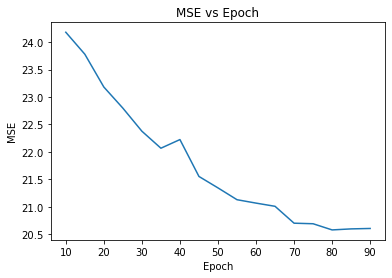

In [411]:
# Find the index of the minimum MSE value
min_mse_index = mse_list.index(min(mse_list))
scores['Neural Network_Relu'] = ('-',mse_list[min_mse_index])
# Print the minimum MSE value and corresponding epoch value
print('Minimum MSE:', mse_list[min_mse_index], '- Epoch:', epoch_list[min_mse_index])

# Create a plot to visualize the relationship between MSE and epoch
plt.plot(epoch_list, mse_list)
plt.title('MSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

The model seems to have consistency in terms of result, as the higher epoch gives me better results and doesn't look overfitting if we see MSE and loss in each step. However, predictions are still not looking good, which make suspect the problem is in the pre-processing.

Try different activation function and optimizer to see if MSE decrease

In [388]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define model with different activation function
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(input_shape,)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='linear'))

# Compile the model with different optimizer
optimizer = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model for different numbers of epochs
epochs = range(10, 91, 5)
epoch_list = []
mse_list = []
for epoch in epochs:
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, verbose=0)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mse_list.append(mse)
    epoch_list.append(epoch)
    print(f"Epoch {epoch} - Validation MSE: {mse}")


The `lr` argument is deprecated, use `learning_rate` instead.


653/653 [==============================] - 0s 558us/step
Epoch 10 - Validation MSE: 518891.3090462979
653/653 [==============================] - 0s 585us/step
Epoch 15 - Validation MSE: 395784.0904332895
653/653 [==============================] - 0s 588us/step
Epoch 20 - Validation MSE: 388420.1703059616
653/653 [==============================] - 0s 580us/step
Epoch 25 - Validation MSE: 409880.6173026309
653/653 [==============================] - 0s 627us/step
Epoch 30 - Validation MSE: 674647.6413334471
653/653 [==============================] - 0s 573us/step
Epoch 35 - Validation MSE: 390975.77534509083
653/653 [==============================] - 0s 602us/step
Epoch 40 - Validation MSE: 499252.0514805503
653/653 [==============================] - 0s 564us/step
Epoch 45 - Validation MSE: 682853.4662755212
653/653 [==============================] - 0s 572us/step
Epoch 50 - Validation MSE: 627622.3854662686
653/653 [==============================] - 0s 600us/step
Epoch 55 - Validation MS

Minimum MSE: 383490.08564832725 - Epoch: 60


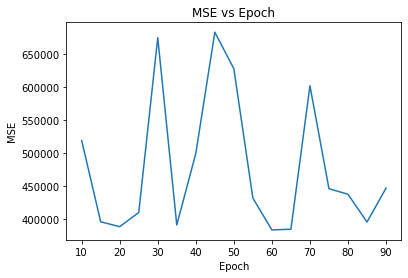

In [389]:
# Find the index of the minimum MSE value
min_mse_index = mse_list.index(min(mse_list))
if mse_list[min_mse_index]< 50:
    scores['Neural Network_Sig'] = ('-',mse_list[min_mse_index])
# Print the minimum MSE value and corresponding epoch value
print('Minimum MSE:', mse_list[min_mse_index], '- Epoch:', epoch_list[min_mse_index])

# Create a plot to visualize the relationship between MSE and epoch
plt.plot(epoch_list, mse_list)
plt.title('MSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

I tried different activation functions and optimizer to check if this could help the model to make better predictions but as we can see in the graph above and seeing the minimum MSE, it is clear that the model is not working properly seenig such random behaviour by iterating epoch and a huge minimum MSE. In this case, I tried different functions for the hidden layers (sigmoid and tanh) and the SGD optimizer with learning rate 0.01 and momentum 0.9 to minimize the mean squared error loss function.

Train best model to submit in Kaggle

In [390]:
# look at ranking in terms of MSE
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()

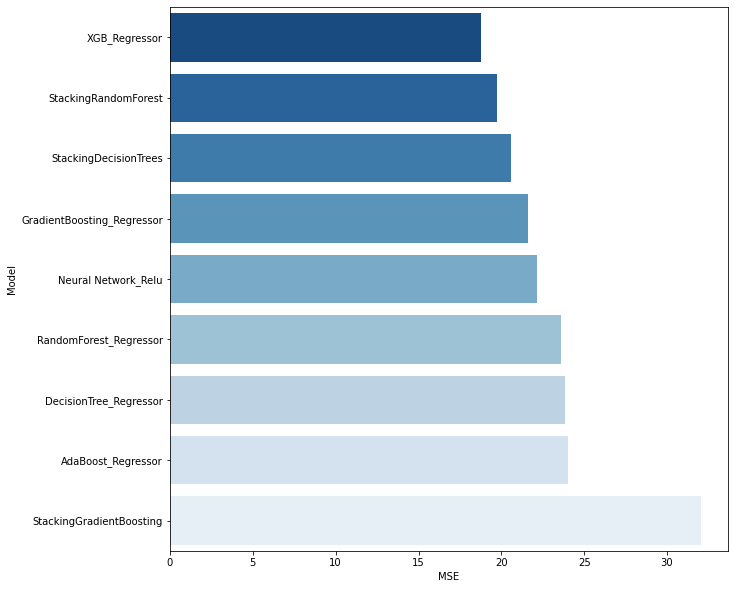

In [391]:
ranking.columns = ['Model', 'Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

In [397]:
Xgb = XGBRegressor(learning_rate=1, max_depth=3, min_child_weight=9, objective='reg:squarederror', reg_lambda=1.5, seed=42)
Xgb.fit(X_train, y_train)
y_hat= Xgb.predict(X_test)

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [339]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": pred_sample['icustay_id'], "LOS": y_hat_test})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)

Model Interpretability: I will use Python's shap package. This package has fast SHAP functions for models that belong to the family of trees (shap.TreeExplainer) or deep learning (neural network, shap.DeepExplainer), but for any other type of model (e.g. K-Nearest Neighbors) one has to stick to the general function shap.KernelExplainer

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


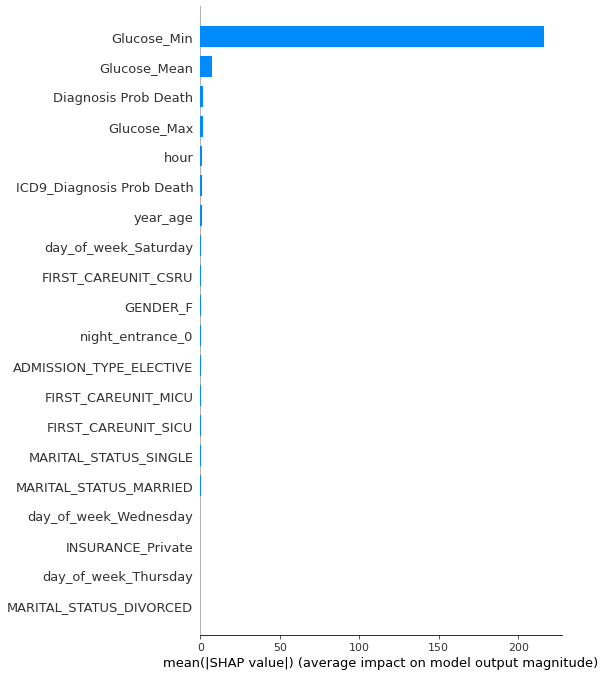

In [421]:
explainer = shap.TreeExplainer(Xgb) 
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

The SHAP values represent the impact of each feature on the model's output. Positive SHAP values indicate that a feature increases the predicted value, while negative SHAP values indicate that a feature decreases the predicted value. In this case, we can see Glucose Min and Glucose_Mean are the features with more impact in the prediction, specifically in the Length of Stay of the patient. 

In [422]:
# Plot the explanation of one observation
mytarget = 1#5

shap.initjs() ## needed to be added in each cell to get the plot to work

shap.force_plot(explainer.expected_value, shap_values[mytarget,:], X_test.iloc[mytarget,:])
## Explain

The explainer.expected_value argument is the expected value of the model, which is the average prediction of the model for all observations. The shap_values[mytarget,:] argument contains the SHAP values for the chosen observation, which represent the contribution of each feature to the predicted value for that observation. Finally, X_test.iloc[mytarget,:] is the chosen observation itself, which contains the values of all features for that observation. I this case, the observation LOS is 16.67. Consistent with the graph above. 

In [423]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame(zip(X_test.columns,X_test.mean(),X_test.iloc[mytarget,:],shap_values[mytarget,:]), 
             columns=['feature','avg_value','mytarget_value','shap_value'])

# Sort by shap_value in descending order
df_sorted_desc = df.sort_values(by='shap_value', ascending=False)

# Sort by shap_value in ascending order
df_sorted_asc = df.sort_values(by='shap_value', ascending=True)

df_sorted_desc.head()

,feature,avg_value,mytarget_value,shap_value
2,Glucose_Mean,-0.601354,-0.602089,7.071146
48,day_of_week_Saturday,-0.317816,10.582497,2.093652
6,hour,-0.380201,-0.380763,1.046781
7,year_age,-115.290683,-115.208810,0.949959
41,MARITAL_STATUS_SINGLE,-0.541543,-1.834812,0.586107


In [424]:
df_sorted_asc.head()

,feature,avg_value,mytarget_value,shap_value
0,Glucose_Min,-0.541037,-0.541661,-214.920883
5,ICD9_Diagnosis Prob Death,-0.358246,-0.358826,-1.291199
1,Glucose_Max,-0.680822,-0.681703,-1.251368
4,Diagnosis Prob Death,-0.358246,-0.358826,-0.900055
10,GENDER_F,-0.782301,1.851701,-0.501402


The feature column contains the names of the features in the model, while the avg_value column contains the average values of each feature across the test dataset. The mytarget_value column contains the values of each feature for the selected observation, while the shap_value column contains the corresponding SHAP values.

This DataFrame provides a useful summary of the feature contributions to the prediction for the selected observation. As we can see, consistent with the previous analysis.

Conclusions: despite implementing different techniques the predictions doesn't look to improve no matter what model I am using. This give me the hint that there is probably a step in the pre-processing part that is messing the models in a way that none of them are able to predict correctly. 